# Step 1: Install and Import Libraries

In [6]:
# Install libraries
!pip install yfinance prophet

In [7]:
# Data processin# Import libraries
# Data processing
import pandas as pd
import numpy as np

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Hyperparameter tuning
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

# Step 2: Pull Data

In [8]:
# Load data and preprocess
file_path = '/content/data_kelompok.xlsx'
data = pd.read_excel(file_path)

# Rename columns for Prophet
data = data.rename(columns={'Tanggal': 'ds', 'Penumpang': 'y'})

# Convert columns to appropriate types
data['ds'] = pd.to_datetime(data['ds'])
data['y'] = data['y'].astype(float)


In [9]:
# Information on the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      550 non-null    datetime64[ns]
 1   y       550 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.7 KB


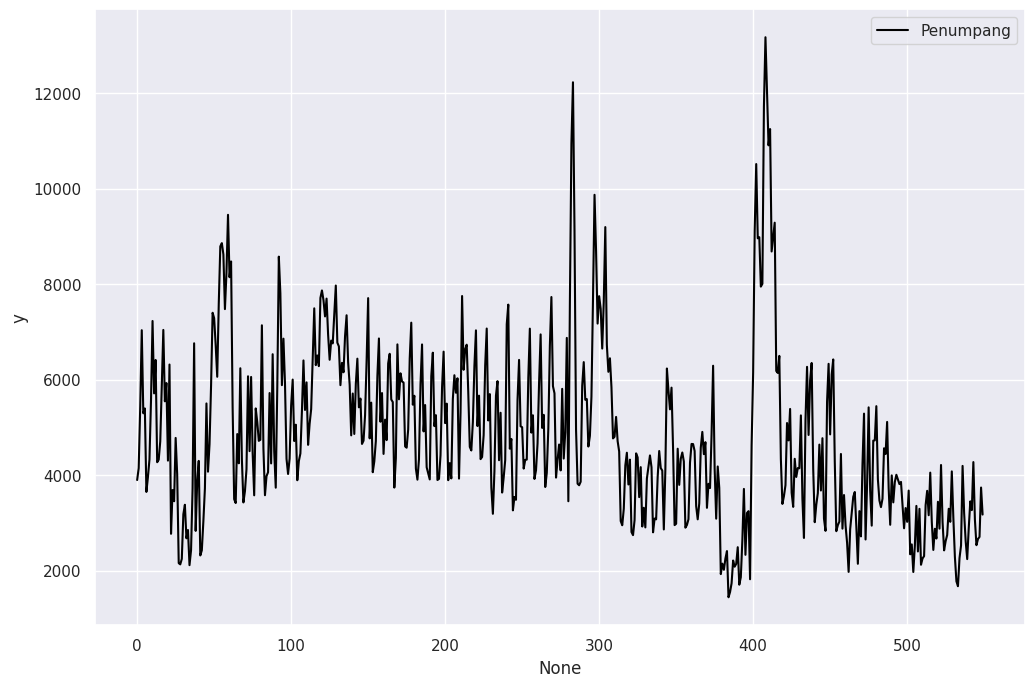

In [10]:
sns.set(rc={'figure.figsize': (12, 8)})
sns.lineplot(x=data.index, y=data['y'], color='black')  # Set color to black
plt.legend(['Penumpang'])
plt.show()

# Step 3: Train Test Split

In [11]:
# Split into train and test data
train_data = data[:321]  # Data latih
test_data = data[321:]   # Data uji

# Check the shape of the dataset
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (321, 2)
Test data shape: (229, 2)


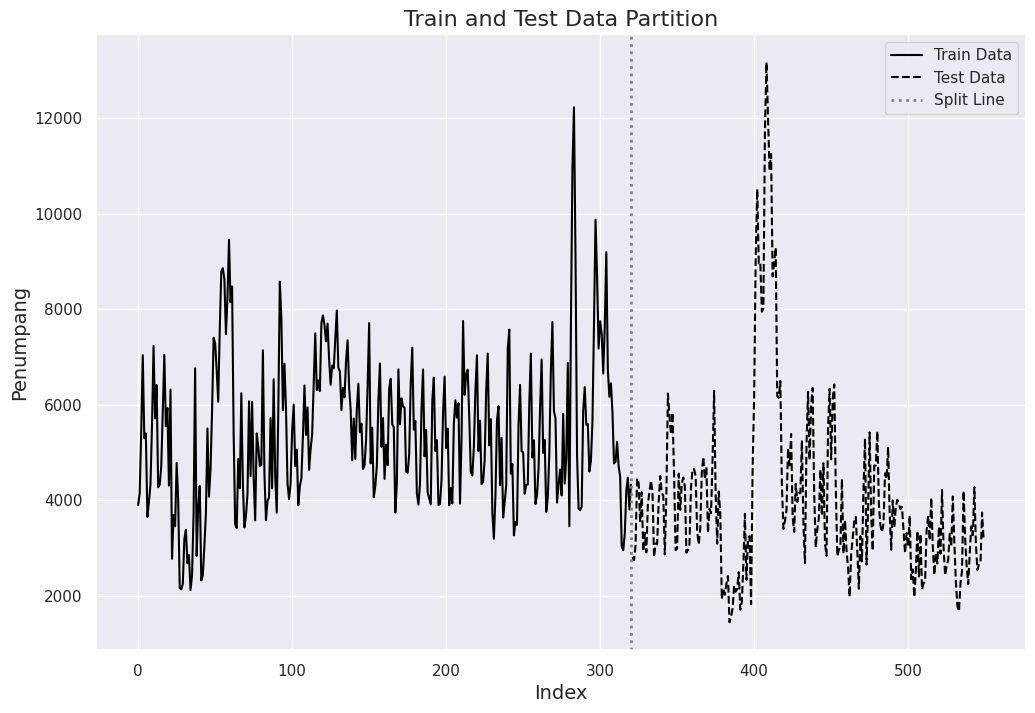

In [12]:
# Set figure size
sns.set(rc={'figure.figsize': (12, 8)})

# Plot train data (garis hitam lurus)
plt.plot(train_data.index, train_data['y'], label='Train Data', color='black', linestyle='-')

# Plot test data (garis hitam titik-titik)
plt.plot(test_data.index, test_data['y'], label='Test Data', color='black', linestyle='--')

# Add a vertical line to mark the split
plt.axvline(x=train_data.index[-1], color='gray', linestyle=':', linewidth=2, label='Split Line')

# Add title, legend, and labels
plt.title("Train and Test Data Partition", fontsize=16)
plt.xlabel("Index", fontsize=14)
plt.ylabel("Penumpang", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Model with Holiday Effect and Event Effect

## Step 4.1: Build Model with Holiday and Event Effect

In [13]:
# Misalkan lebaran dan natal diset secara umum untuk setiap tahun
events = pd.DataFrame({
    'holiday': ['lebaran', 'liburan', 'natal', 'lebaran', 'liburan', 'natal'],
    'ds': pd.to_datetime(['2023-04-21', '2023-06-29', '2023-12-25', '2024-04-09', '2024-06-23', '2024-12-25']),
    'lower_window': [-25, -23, -18, -25, -10, -14],
    'upper_window': [12, 6, 9, 12, 22, 9]
})

In [14]:

# Set up parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [1, 5, 10, 15],
    'seasonality_mode': ['additive', 'multiplicative'],
    'holidays_prior_scale': [1, 5, 10, 15]  # Add holiday_prior_scale parameter
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Create a list to store MAPE values for each combination
mapes = []

for params in all_params:
    # Add holidays to the Prophet parameters
    params['holidays'] = events  # Ensure 'events' contains your holiday data

    # Fit a model using one parameter combination
    m = Prophet(**params).fit(train_data)

    # Cross-validation
    df_cv = cross_validation(m, initial='200 days', period='30 days', horizon='60 days', parallel="processes")

    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)

    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])

# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

# Save the tuning results to an Excel file
tuning_results.to_excel("tuning_results.xlsx", index=False)

# Print the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)


Streaming output truncated to the last 5000 lines.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpolessd_p/affcy43g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpolessd_p/z65dxsc_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64628', 'data', 'file=/tmp/tmpolessd_p/affcy43g.json', 'init=/tmp/tmpolessd_p/z65dxsc_.json', 'output', 'file=/tmp/tmpolessd_p/prophet_modelityjwuph/prophet_model-20241218045225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:52:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:52:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done 

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1, 'holidays':    holiday         ds  lower_window  upper_window
0  lebaran 2023-04-21           -25            12
1  liburan 2023-06-29           -23             6
2    natal 2023-12-25           -18             9
3  lebaran 2024-04-09           -25            12
4  liburan 2024-06-23           -10            22
5    natal 2024-12-25           -14             9}


In [15]:
auto_model = Prophet( holidays=events,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    holidays_prior_scale=best_params['holidays_prior_scale']  # Add holiday_prior_scale
)

auto_model.add_seasonality(name='weekly', period=7, fourier_order=3)  # Musiman tambahan

# Fit the model on the training dataset
auto_model.fit(train_data)

# Cross-validation
auto_model_cv = cross_validation(auto_model, initial='200 days', period='30 days', horizon='60 days', parallel="processes")

# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)
print("Cross-Validation MAPE (Train):", auto_model_p['mape'].values[0])


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpolessd_p/0j8s3fcx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpolessd_p/s2d_n5_f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61793', 'data', 'file=/tmp/tmpolessd_p/0j8s3fcx.json', 'init=/tmp/tmpolessd_p/s2d_n5_f.json', 'output', 'file=/tmp/tmpolessd_p/prophet_model6vvofzl2/prophet_model-20241218045634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:56:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:56:34 - cmdstanpy - INFO - Chain [1] do

Cross-Validation MAPE (Train): 0.1547434815275234


In [16]:
# Create future DataFrame for predictions
# Adjust the number of periods as needed (e.g., for the next 60 days)
future = auto_model.make_future_dataframe(periods=229)

# Make predictions
forecast = auto_model.predict(future)

# Calculate MAPE on test data
test_forecast = forecast.set_index('ds').loc[test_data['ds']]
mape_test = mape(test_data['y'], test_forecast['yhat'])
print("MAPE on Test Data:", mape_test)



MAPE on Test Data: 0.2314518790264685


In [17]:
# Pilih kolom yang ingin disimpan
forecast_229_days = forecast.tail(229)[['ds', 'yhat']]  # Hanya tanggal dan nilai prediksi
forecast_229_days.to_excel("forecast_229_days.xlsx", index=False)

print("Forecast (yhat) for 229 days ahead has been saved to 'forecast_229_days.xlsx'")


Forecast (yhat) for 229 days ahead has been saved to 'forecast_229_days.xlsx'


# Nilai Parameter Model Prophet

## Nilai Parameter Trend

In [ ]:
print(auto_model.params['delta'])  # Parameter perubahan di sekitar changepoints
print(auto_model.params['k'])     # Slope tren awal
print(auto_model.params['m'])     # Intercept tren awal

[[-2.06437e-08 -3.50570e-09 -1.02274e-08 -1.31876e-09  2.81129e-08
   7.67785e-09  1.15523e-08  6.45452e-09  8.31809e-10 -1.89924e-07
  -3.70271e-05 -8.35363e-02 -1.38719e-01 -6.30023e-02 -1.56517e-02
  -5.94907e-05 -2.83129e-03 -3.07215e-08 -1.52176e-04 -3.09763e-03
  -1.47937e-02 -1.27662e-02 -6.97104e-03 -2.36839e-03 -1.33489e-02]]
[[0.164997]]
[[0.394256]]


In [ ]:
print(auto_model.seasonalities)


OrderedDict([('weekly', {'period': 7, 'fourier_order': 3, 'prior_scale': 1.0, 'mode': 'additive', 'condition_name': None})])


In [ ]:
# Menampilkan semua parameter model
for param_name, param_values in auto_model.params.items():
    print(f"Parameter: {param_name}")
    print(param_values)

Parameter: lp__
[[747.52]]
Parameter: k
[[0.164997]]
Parameter: m
[[0.394256]]
Parameter: delta
[[-2.06437e-08 -3.50570e-09 -1.02274e-08 -1.31876e-09  2.81129e-08
   7.67785e-09  1.15523e-08  6.45452e-09  8.31809e-10 -1.89924e-07
  -3.70271e-05 -8.35363e-02 -1.38719e-01 -6.30023e-02 -1.56517e-02
  -5.94907e-05 -2.83129e-03 -3.07215e-08 -1.52176e-04 -3.09763e-03
  -1.47937e-02 -1.27662e-02 -6.97104e-03 -2.36839e-03 -1.33489e-02]]
Parameter: sigma_obs
[[0.0575105]]
Parameter: beta
[[ 0.0769711  -0.0209615   0.00934771 -0.00325849 -0.0241318  -0.00838147
   0.0745995  -0.0181052   0.251471    0.104083   -0.0774768   0.178182
   0.280789    0.3895      0.345778    0.220481    0.195567    0.25626
   0.219789    0.20843    -0.139419   -0.0804106  -0.120866   -0.275721
   0.0847844  -0.0770427  -0.151507   -0.152758   -0.195632   -0.214465
   0.249116   -0.227553   -0.205109   -0.194355   -0.172241   -0.145873
  -0.0969189   0.148768   -0.055201   -0.106958   -0.060504   -0.167561
  -0.136678

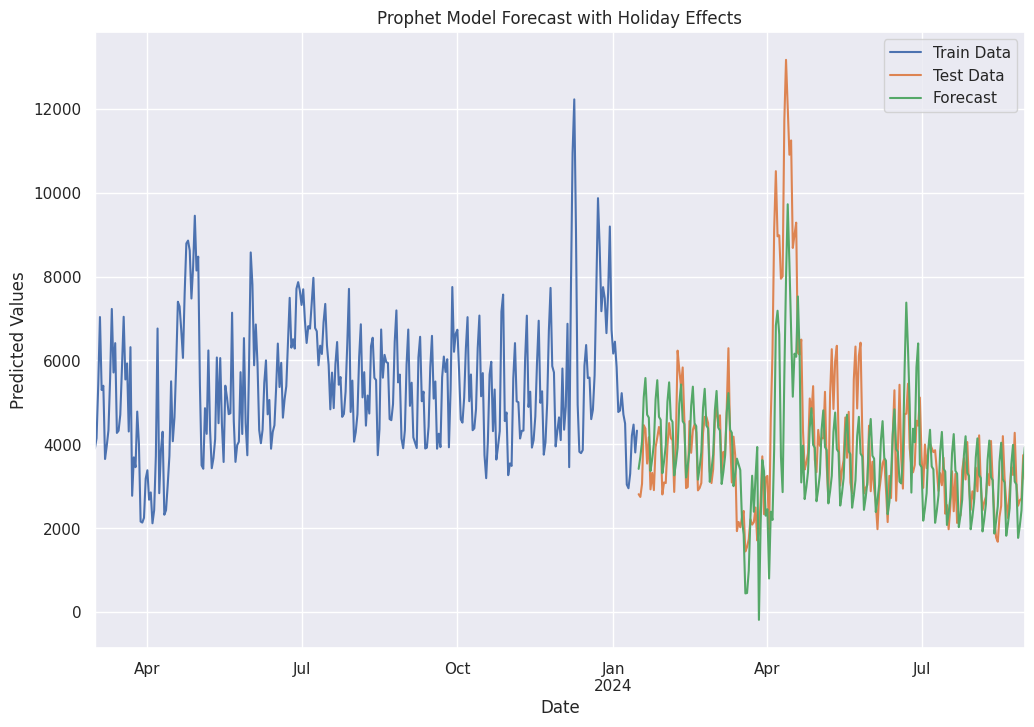

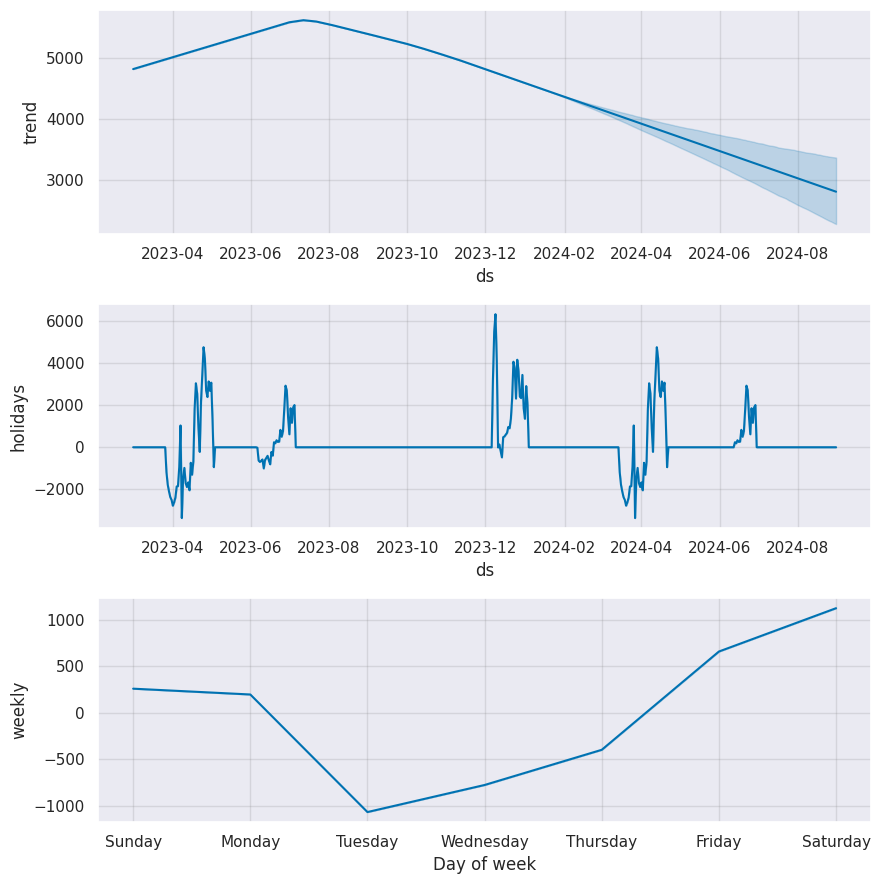

In [ ]:
# Plot forecast results with holiday effects for test data
fig, ax = plt.subplots(figsize=(12, 8))
train_data.plot(x='ds', y='y', ax=ax, label='Train Data')
test_data.plot(x='ds', y='y', ax=ax, label='Test Data')
test_forecast.plot(y='yhat', ax=ax, label='Forecast')
plt.legend(['Train Data', 'Test Data', 'Forecast'])
plt.title('Prophet Model Forecast with Holiday Effects')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.show()

# Plot forecast components to see holiday effects
fig2 = auto_model.plot_components(forecast)
plt.show()

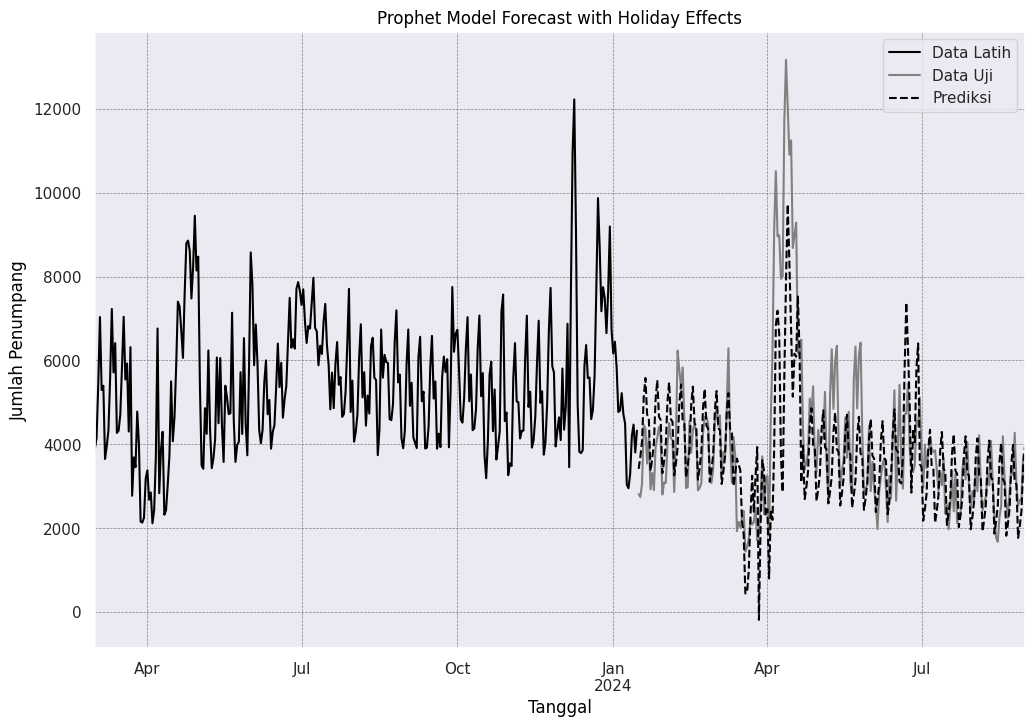

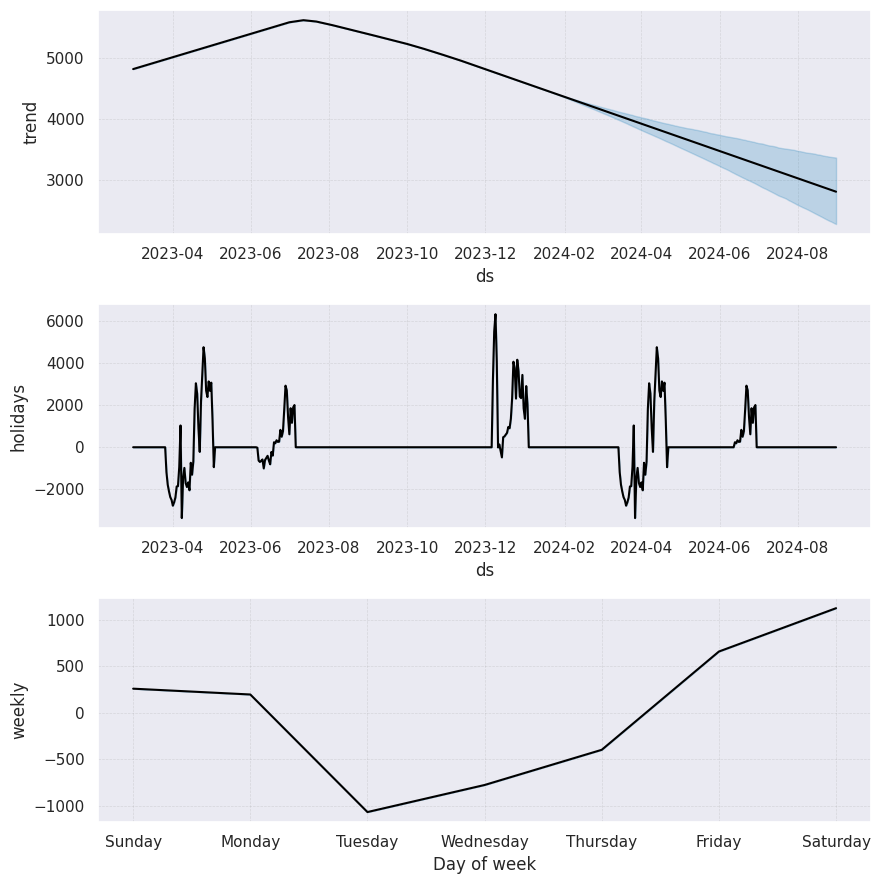

In [ ]:

# Plot forecast results with holiday effects for test data
fig, ax = plt.subplots(figsize=(12, 8))
train_data.plot(x='ds', y='y', ax=ax, label='Data Latih', color='black', linestyle='-')
test_data.plot(x='ds', y='y', ax=ax, label='Data Uji', color='gray', linestyle='-')
test_forecast.plot(y='yhat', ax=ax, label='Prediksi', color='black', linestyle='--')
plt.legend(['Data Latih', 'Data Uji', 'Prediksi'])
plt.title('Prophet Model Forecast with Holiday Effects', color='black')
plt.xlabel('Tanggal', color='black')
plt.ylabel('Jumlah Penumpang', color='black')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

# Plot forecast components to see holiday effects
fig2 = auto_model.plot_components(forecast)
for ax in fig2.axes:
    for line in ax.lines:
        line.set_color('black')  # Change all lines to black
        if '--' in line.get_linestyle():  # Ensure dashed line for forecast components if applicable
            line.set_linestyle('--')
    ax.grid(color='gray', linestyle='--', linewidth=0.5)  # Grid lines in gray and dashed
plt.show()

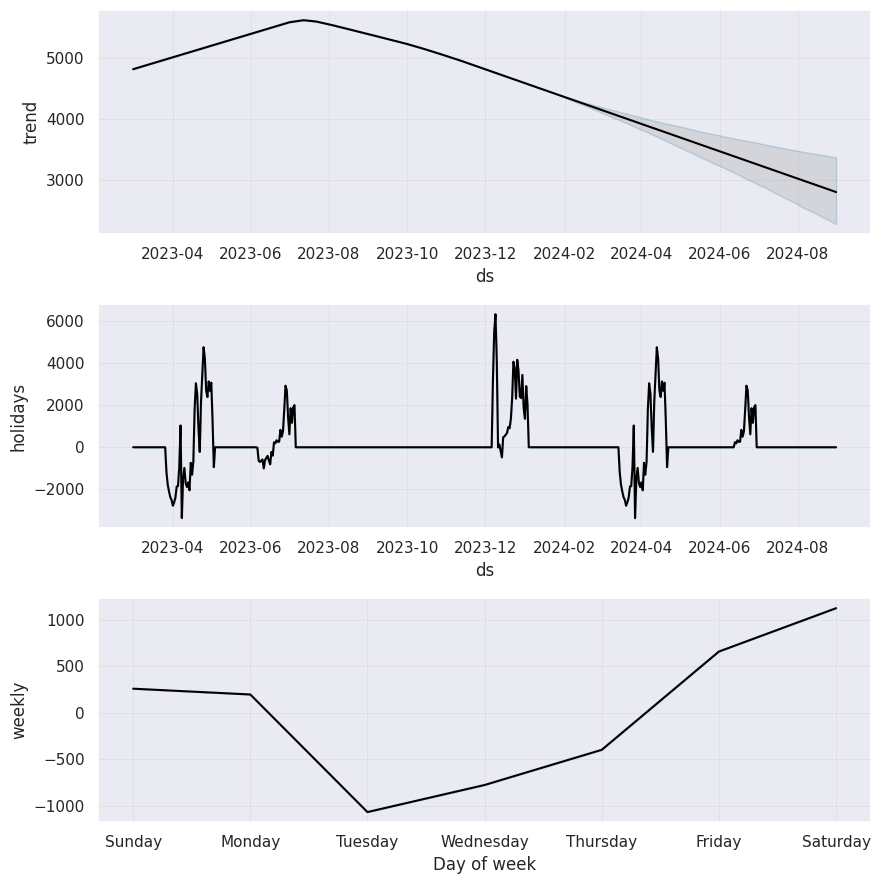

In [ ]:
# Plot components with uncertainty intervals changed to gray
fig2 = auto_model.plot_components(forecast)

# Loop through axes to update uncertainty intervals
for ax in fig2.axes:
    for collection in ax.collections:  # Identify uncertainty areas
        collection.set_facecolor('gray')  # Change color to gray
        collection.set_alpha(0.2)  # Adjust transparency for better visibility
    for line in ax.lines:  # Ensure lines remain black
        line.set_color('black')
    ax.grid(color='gray', linestyle='--', linewidth=0.5)  # Gray grid

plt.show()

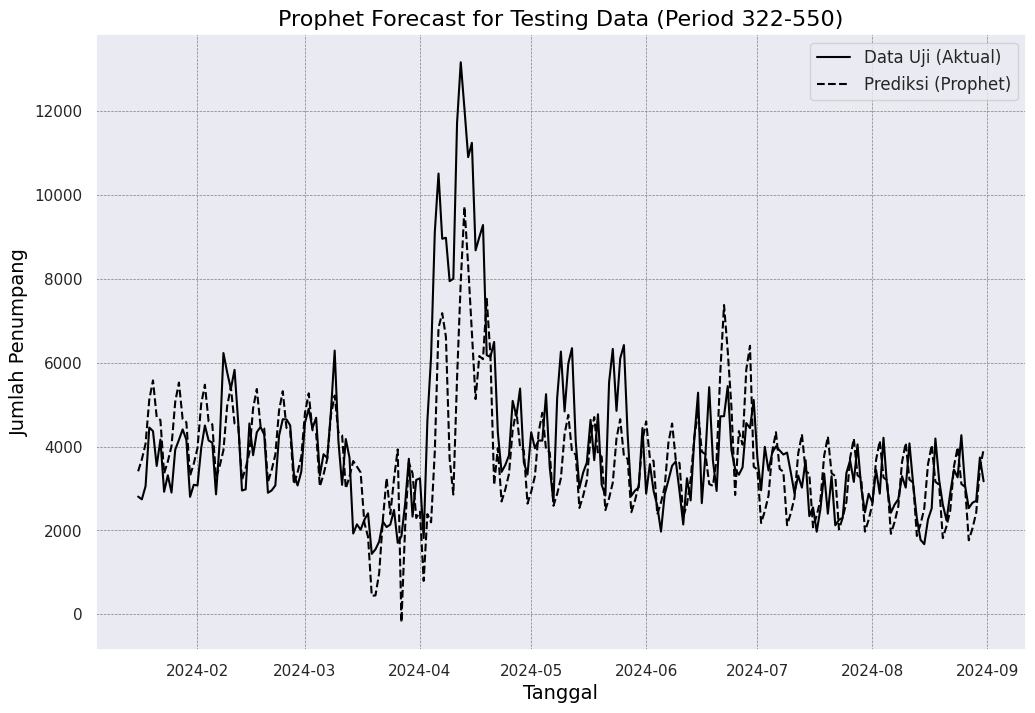

In [ ]:
import matplotlib.pyplot as plt

# Filter data uji dari hasil prediksi
forecast_test = forecast.iloc[321:550]  # Ambil periode 322-550 (data uji)
test_actual = test_data.reset_index()  # Reset index untuk mencocokkan dengan forecast

# Plot data uji dan prediksi
fig, ax = plt.subplots(figsize=(12, 8))

# Data uji aktual
plt.plot(test_actual['ds'], test_actual['y'], label='Data Uji (Aktual)', color='black', linestyle='-')

# Prediksi Prophet
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Prediksi (Prophet)', color='black', linestyle='--')

# Tambahkan legend, title, dan label
plt.legend(fontsize=12)
plt.title('Prophet Forecast for Testing Data (Period 322-550)', fontsize=16, color='black')
plt.xlabel('Tanggal', fontsize=14, color='black')
plt.ylabel('Jumlah Penumpang', fontsize=14, color='black')

# Tambahkan grid
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Tampilkan plot
plt.show()



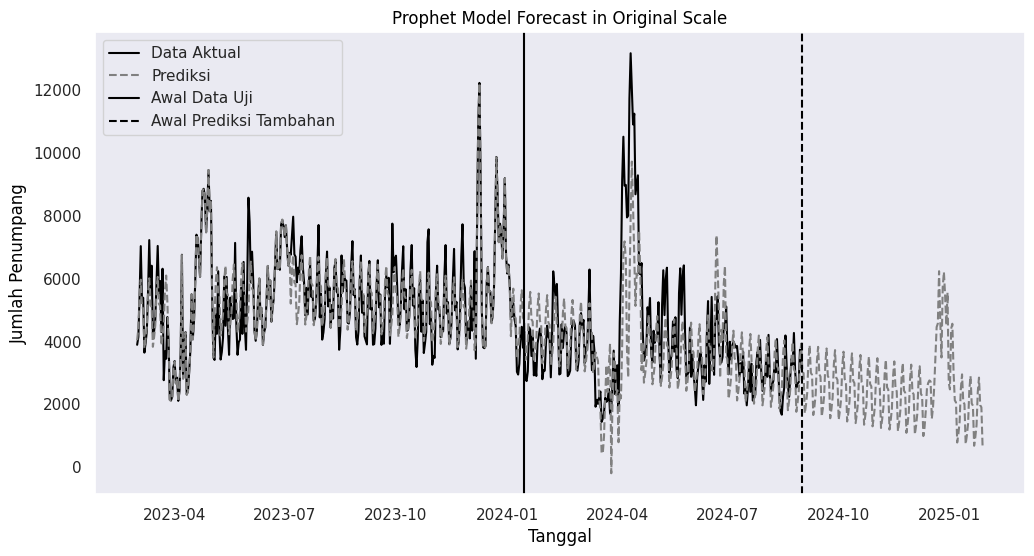

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extend future prediction by 300 additional periods after test data
future_all = auto_model.make_future_dataframe(periods=229 + 150)

# Predict future values
forecast_all = auto_model.predict(future_all)

# Plot original data, train/test data, and future forecast
plt.figure(figsize=(12, 6))

# Plot the actual data (train + test combined) in black
plt.plot(data['ds'], data['y'], label='Data Aktual', color='black')

# Plot the forecasted values as a dashed line in gray
plt.plot(forecast_all['ds'], forecast_all['yhat'], label='Prediksi', color='gray', linestyle='--')

# Highlight the beginning of test data and additional forecast period with dashed vertical lines
plt.axvline(x=train_data['ds'].iloc[-1], color='black', linestyle='-', label='Awal Data Uji')
plt.axvline(x=future_all['ds'].iloc[-150], color='black', linestyle='--', label='Awal Prediksi Tambahan')

# Add labels and title
plt.title('Prophet Model Forecast in Original Scale', color='black')
plt.xlabel('Tanggal', color='black')
plt.ylabel('Jumlah Penumpang', color='black')
plt.legend()
plt.grid(False)  # Ensure grid lines do not interfere with black-and-white aesthetic
plt.show()


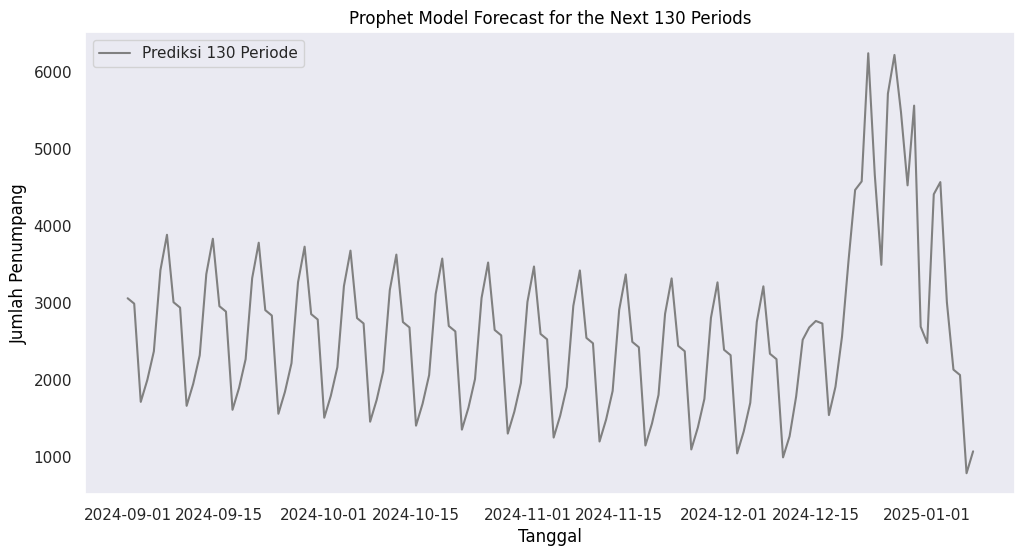

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Extend future prediction by 229 + 130 additional periods after test data
future_all = auto_model.make_future_dataframe(periods=229 + 130)

# Predict future values
forecast_all = auto_model.predict(future_all)

# Plot the forecasted values for the next 150 periods
plt.figure(figsize=(12, 6))

# Plot the forecasted values for the next 150 periods as a solid line
plt.plot(forecast_all['ds'][-130:], forecast_all['yhat'][-130:], label='Prediksi 130 Periode', color='gray', linestyle='-')

# Add labels and title
plt.title('Prophet Model Forecast for the Next 130 Periods', color='black')
plt.xlabel('Tanggal', color='black')
plt.ylabel('Jumlah Penumpang', color='black')
plt.legend()
plt.grid(False)  # Ensure grid lines do not interfere with black-and-white aesthetic
plt.show()


In [ ]:
forecast_all.to_excel('forecast_results.xlsx', index=False)